In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
import glob

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
#Separating data for each drug

def get_drug_pos_map(test_df, drugs):
    drug_pos_map = {d:[] for d in drugs}
    for i, row in test_df.iterrows():
        drug_pos_map[row['D']].append(i)
    return drug_pos_map

In [4]:
#Arrange the drugs in descending order of correlation

def sort_drugs_corr(drugs, test_df, predicted):
    drug_corr_map = {}
    drug_pos_map = get_drug_pos_map(test_df, drugs)
    for d in drugs:
        test_vals = np.take(test_df['AUC'], drug_pos_map[d])
        pred_vals = np.take(predicted, drug_pos_map[d])
        drug_corr_map[d] = stats.spearmanr(test_vals, pred_vals)[0]
    return {drug:corr for drug,corr in sorted(drug_corr_map.items(), key=lambda item:item[1], reverse=True)}


In [5]:
def plot_drug_performance(drug_corr_map):
    fig = plt.figure(figsize=(9, 8))
    ax = fig.add_subplot(111)
    x_red = []
    y_red = []
    x_blue = []
    y_blue = []
    for d in drug_corr_map.keys():
        if drug_corr_map[d] > 0.5:
            x_red.append(d)
            y_red.append(drug_corr_map[d])
        else:
            x_blue.append(d)
            y_blue.append(drug_corr_map[d])
    
    ratio = float(len(x_red))/float(len(drug_corr_map.keys()))
    print('Red ratio = ' + str(ratio))
    ax.bar(x_red, y_red, color='red', width=1.0)
    ax.bar(x_blue, y_blue, color='blue', width=1.0)
    ax.set_xticks([])
    ax.set_xlabel('Drugs')
    ax.set_ylabel('Performance\nSpearman ρ (Predicted vs. Actual)')
    plt.show()
    return fig

In [6]:
def create_drug_performance_plot(drugs, test_df, predicted_result):
    drug_corr_map = sort_drugs_corr(drugs, test_df, predicted_result)
    fig_drug_perf = plot_drug_performance(drug_corr_map)
    print('Median spearman rho:', np.median(list(drug_corr_map.values())))
    return fig_drug_perf

In [7]:
def get_boxplot(test_df, predicted, x_title, y_title):
    
    df = pd.DataFrame(list(zip(test_df['AUC'], predicted)), columns=['t', 'p'])
    df = df.sort_values(by=['t'])

    data = []
    for i in range(9):
        temp = []
        data.append(temp)

    for i, row in df.iterrows():
        if row['t'] < 0.3:
            data[0].append(row['p'])
        elif row['t'] < 0.4:
            data[1].append(row['p'])
        elif row['t'] < 0.5:
            data[2].append(row['p'])
        elif row['t'] < 0.6:
            data[3].append(row['p'])
        elif row['t'] < 0.7:
            data[4].append(row['p'])
        elif row['t'] < 0.8:
            data[5].append(row['p'])
        elif row['t'] < 0.9:
            data[6].append(row['p'])
        elif row['t'] < 1.0:
            data[7].append(row['p'])
        else:
            data[8].append(row['p'])
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    ax.boxplot(data, showfliers=False, widths=0.99, patch_artist=True)
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.set_xticks(np.arange(.5, 10, 1))
    ax.set_xticklabels(['0', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', 'Inf'])
    ax.grid(True)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    
    plt.show()
    
    return fig


In [15]:
def compare_corr(x_test_df, y_test_df, x_label, y_label, x_title, y_title):
    X_corr = []
    Y_corr = []
    x_drug_pos_map = get_drug_pos_map(x_test_df, drugs)
    y_drug_pos_map = get_drug_pos_map(y_test_df, drugs)
    for d in drugs:
        x_test_vals = np.take(x_test_df['AUC'], x_drug_pos_map[d])
        y_test_vals = np.take(y_test_df['AUC'], y_drug_pos_map[d])
        X_vals = np.take(x_label, x_drug_pos_map[d])
        Y_vals = np.take(y_label, y_drug_pos_map[d])
        X_c = Y_c = 0
        all_same = np.all(X_vals == X_vals[0])
        if all_same:
            X_c = 0
        else:
            X_c = stats.spearmanr(X_vals, x_test_vals)[0]
        all_same = np.all(Y_vals == Y_vals[0])
        if all_same:
            Y_c = 0
        else:
            Y_c = stats.spearmanr(Y_vals, y_test_vals)[0]
        X_corr.append(X_c)
        Y_corr.append(Y_c)
        #if X_c > (Y_c + 0.1) and X_c > 0.5:
        #    print(d)

    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111)
    ax.scatter(X_corr, Y_corr, s = 10)
    
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.show()
    
    return X_corr, Y_corr, fig

In [9]:
def compare_corr_violin(test_df, pred_auc_list, title_list, pos):
    
    corr_list = []
    test_drug_pos_map = dict()
    
    drug_pos_map = get_drug_pos_map(test_df, drugs)
    for d in drugs:
        test_drug_pos_map[d] = np.take(test_df['AUC'], drug_pos_map[d])
    
    for pred_auc in pred_auc_list:
        corr = []
        for d in drugs:
            c = 0
            auc_per_drug = np.take(pred_auc, drug_pos_map[d])
            
            all_same = np.all(auc_per_drug == auc_per_drug[0])
            if all_same:
                c = 0
            else:
                c = stats.spearmanr(test_drug_pos_map[d], auc_per_drug)[0]
            corr.append(c)
        corr_list.append(corr)

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.violinplot(corr_list, pos, showmedians = True)
    ax.set_xticks(pos)
    ax.set_xticklabels(title_list)
    ax.hlines([0, 0.2, 0.4], 0, pos[len(pos)-1] + 1, linestyles='dotted')
    plt.show()
    
    return fig

In [10]:
def get_corr_values(ntype):
    all_pred = []
    sum = 0.0
    for i in range(1, 6):
        test_file = '../data/' + str(i) + '_drugcell_test.txt'
        pred_file = '../result/' + str(i) + '_drugcell_' + ntype + '.predict'
        test = pd.read_csv(test_file, sep='\t', header=None, names=['C', 'D', 'AUC'])['AUC']
        pred = np.loadtxt(pred_file)
        all_pred = np.concatenate((all_pred, pred), axis=0)
        corr = stats.spearmanr(pred, test)[0]
        print('Correlation for #', i, corr)
        sum += corr
    print('Avg Correlation: {:.3f}'.format(sum/5.0))
    return all_pred

In [11]:
def compare_model(net_type):

    nest_pred = get_corr_values(net_type)
    corr = stats.spearmanr(nest_pred, test_df['AUC'])[0]
    print('Correlation: {:.3f}'.format(corr))

    boxplot = get_boxplot(test_df, nest_pred, "True AUC", "NeST " + net_type + " Predicted AUC")
    boxplot.savefig('../plots/nest_' + net_type + '_drugcell_auc.png')

    X_c, Y_c, cc_scatterplot = compare_corr(test_df, test_df, drugcell_pred_cv, 
                                            pcnet_pred, "Drugcell", "NeST " + net_type + " Drugcell")
    print('t-test p-value:', stats.ttest_ind(X_c, Y_c)[1])
    cc_scatterplot.savefig('../plots/nest_' + net_type + 'drugcell_vs_drugcell.png', bbox_inches = 'tight')

    drug_perf_barplot = create_drug_performance_plot(drugs, test_df, nest_pred)
    drug_perf_barplot.savefig('../plots/nest_' + net_type + '_drug_perf.png')
    
    elastic_net_pred = np.loadtxt('../result/elastic_net.predict')
    corr = stats.spearmanr(elastic_net_pred, test_df['AUC'])[0]
    print('Elastic Net: {:.3f}'.format(corr))

    X_c, Y_c, en_scatterplot = compare_corr(test_df, test_df, elastic_net_pred, nest_pred, 
                                    "Elastic Net", "NeST " + net_type + " Drugcell")
    print('t-test p-value:', stats.ttest_ind(X_c, Y_c)[1])
    en_scatterplot.savefig('../plots/nest_' + net_type + '_drugcell_vs_elastic_net.png', bbox_inches = 'tight')

In [12]:
test_df = pd.read_csv('../data/drugcell_all.txt', sep='\t', header=None, names=['C', 'D', 'AUC'])
drugs = pd.read_csv('../data/drug2ind.txt', sep='\t', header=None, names=['I', 'D'])['D']

In [ ]:
net_type = 'clinical_trial'

nest_ct_pred = get_corr_values('ct')
corr = stats.spearmanr(nest_ct_pred, test_df['AUC'])[0]
print('Correlation: {:.3f}'.format(corr))

nest_r_pred = get_corr_values('r')
corr = stats.spearmanr(nest_r_pred, test_df['AUC'])[0]
print('Correlation: {:.3f}'.format(corr))

nest_mf_pred = get_corr_values('mf')
corr = stats.spearmanr(nest_mf_pred, test_df['AUC'])[0]
print('Correlation: {:.3f}'.format(corr))

nest_bb_pred = get_corr_values('bb')
corr = stats.spearmanr(nest_bb_pred, test_df['AUC'])[0]
print('Correlation: {:.3f}'.format(corr))

X_c, Y_c, r_scatterplot = compare_corr(test_df, test_df, nest_r_pred, nest_ct_pred, 
                                        "Random", "Clinical Trial")
print('t-test p-value:', stats.ttest_ind(X_c, Y_c)[1])
r_scatterplot.savefig('../plots/nest_' + net_type + '_drugcell_vs_random.png', bbox_inches = 'tight')

X_c, Y_c, mf_scatterplot = compare_corr(test_df, test_df, nest_mf_pred, nest_ct_pred, 
                                        "Most Frequent", "Clinical Trial")
print('t-test p-value:', stats.ttest_ind(X_c, Y_c)[1])
mf_scatterplot.savefig('../plots/nest_' + net_type + '_drugcell_vs_mf.png', bbox_inches = 'tight')

X_c, Y_c, bb_scatterplot = compare_corr(test_df, test_df, nest_bb_pred, nest_ct_pred, 
                                        "Black Box", "Clinical Trial")
print('t-test p-value:', stats.ttest_ind(X_c, Y_c)[1])
bb_scatterplot.savefig('../plots/nest_' + net_type + '_drugcell_vs_bb.png', bbox_inches = 'tight')

elastic_net_pred = np.loadtxt('../result/elastic_net_clinical_trial.predict')
corr = stats.spearmanr(elastic_net_pred, test_df['AUC'])[0]
print('Elastic Net: {:.3f}'.format(corr))

X_c, Y_c, en_scatterplot = compare_corr(test_df, test_df, elastic_net_pred, nest_ct_pred, 
                                        "Elastic Net", "NeST " + net_type + " Drugcell")
print('t-test p-value:', stats.ttest_ind(X_c, Y_c)[1])
en_scatterplot.savefig('../plots/nest_' + net_type + '_drugcell_vs_elastic_net.png', bbox_inches = 'tight')

In [ ]:
bc_test_df = pd.read_csv('../data/drugcell_breast_cancer_test.txt', sep='\t', header=None, names=['C', 'D', 'AUC'])
nest_all_pred = np.loadtxt('../result/drugcell_breast_cancer.predict')
corr = stats.spearmanr(nest_all_pred, bc_test_df['AUC'])[0]
print('NeST breast cancer cell lines: {:.3f}'.format(corr))

In [ ]:
net_type = 'ddram'

nest_ddram_pred = get_corr_values(net_type)
corr = stats.spearmanr(nest_ddram_pred, test_df['AUC'])[0]
print('Correlation: {:.3f}'.format(corr))

nest_ct_pred = get_corr_values('ct')
corr = stats.spearmanr(nest_ct_pred, test_df['AUC'])[0]
print('Correlation: {:.3f}'.format(corr))

X_c, Y_c, r_scatterplot = compare_corr(test_df, test_df, nest_ddram_pred, nest_ct_pred, 
                                        "DDRAM", "NeST Clinical Trial")
print('t-test p-value:', stats.ttest_ind(X_c, Y_c)[1])
r_scatterplot.savefig('../plots/nest_cinical_trial_drugcell_vs_ddram.png', bbox_inches = 'tight')

Correlation for # 1 0.7696617391105585
Correlation for # 2 0.7652900184707693
Correlation for # 3 0.7670544836219881
Correlation for # 4 0.7619722342373748
Correlation for # 5 0.7720463782746719
Avg Correlation: 0.767
Correlation for # 1 0.7432755088134123
Correlation for # 2 0.7513782656713943
Correlation for # 3 0.752172898269549
Correlation for # 4 0.7515691880346465
Correlation for # 5 0.7462172948321972
Avg Correlation: 0.749


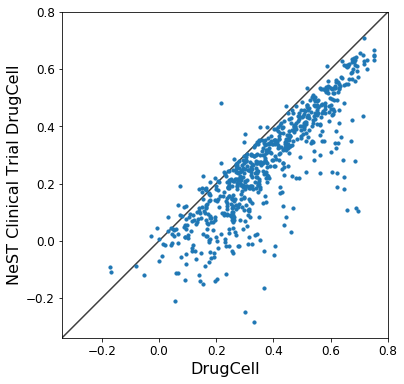

t-test p-value: 1.889183283852479e-27
Correlation for # 1 0.7526732885450811
Correlation for # 2 0.7510513148757297
Correlation for # 3 0.750073121363783
Correlation for # 4 0.7466491991957941
Correlation for # 5 0.7545551098689919
Avg Correlation: 0.751


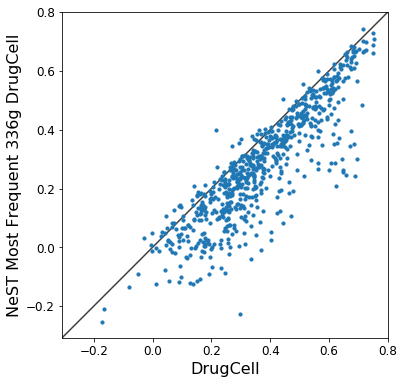

t-test p-value: 3.9547149802821427e-19


In [16]:
dc_pred = []
sum = 0.0
for i in range(1, 6):
    test_file = '../../drugcell/data/' + str(i) + '_drugcell_test.txt'
    pred_file = '../../drugcell/result/' + str(i) + '_drugcell.predict'
    test = pd.read_csv(test_file, sep='\t', header=None, names=['C', 'D', 'AUC'])['AUC']
    pred = np.loadtxt(pred_file)
    dc_pred = np.concatenate((dc_pred, pred), axis=0)
    corr = stats.spearmanr(pred, test)[0]
    print('Correlation for #', i, corr)
    sum += corr
print('Avg Correlation: {:.3f}'.format(sum/5.0))
corr = stats.spearmanr(dc_pred, test_df['AUC'])[0]


nest_ct_pred = get_corr_values('ct')
corr = stats.spearmanr(nest_ct_pred, test_df['AUC'])[0]

X_c, Y_c, r_scatterplot = compare_corr(test_df, test_df, dc_pred, nest_ct_pred, 
                                        "DrugCell", "NeST Clinical Trial DrugCell")
print('t-test p-value:', stats.ttest_ind(X_c, Y_c)[1])
r_scatterplot.savefig('../plots/nest_cinical_trial_drugcell_vs_drugcell.png', bbox_inches = 'tight')


nest_mf_pred = get_corr_values('mf')
corr = stats.spearmanr(nest_ct_pred, test_df['AUC'])[0]

X_c, Y_c, r_scatterplot = compare_corr(test_df, test_df, dc_pred, nest_mf_pred, 
                                        "DrugCell", "NeST Most Frequent 336g DrugCell")
print('t-test p-value:', stats.ttest_ind(X_c, Y_c)[1])
r_scatterplot.savefig('../plots/nest_mf_drugcell_vs_drugcell.png', bbox_inches = 'tight')